In [40]:
import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
TITLE = "VAE_mnist_FCN"

In [41]:
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + '_' + TITLE + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


def reset_graph(seed=420):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# make mnist dataset
def import_mnist_dataset():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    return X_train, X_valid, y_train, y_valid

In [51]:
reset_graph()

n_inputs = 28 * 28
# encoder spec.
n_hidden1 = 1000
n_hidden2 = 500
n_hidden3 = 250
n_hidden4 = 125

# coding unit (latent vector, z)
n_latent = 50

# decoder spec.
n_hidden6 = n_hidden4 # encoder, decoder를 대칭적으로 생성하기 위함
n_hidden7 = n_hidden3
n_hidden8 = n_hidden2
n_hidden9 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.0001
initializer = tf.variance_scaling_initializer()


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, [None, n_inputs])

with tf.name_scope("encoder"):
    hidden1 = tf.layers.dense(X, n_hidden1, kernel_initializer=initializer, activation=tf.nn.relu, name='encoder_hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, kernel_initializer=initializer, activation=tf.nn.relu, name='encoder_hidden2')
    hidden3 = tf.layers.dense(hidden2, n_hidden3, kernel_initializer=initializer, activation=tf.nn.relu, name='encoder_hidden3')
    hidden4 = tf.layers.dense(hidden3, n_hidden4, kernel_initializer=initializer, activation=tf.nn.relu, name='encoder_hidden4')

with tf.name_scope("latent"):
    mean = tf.layers.dense(hidden4, n_latent, kernel_initializer=initializer, activation=None, name='latent_mu')
    sigma = tf.layers.dense(hidden4, n_latent, kernel_initializer=initializer, activation=tf.nn.relu, name='latent_sigma')
    noise = tf.random_normal(tf.shape(sigma), dtype=tf.float32)
    latent = mean + sigma * noise

with tf.name_scope("decoder"):
    hidden6 = tf.layers.dense(latent, n_hidden6, kernel_initializer=initializer, activation=tf.nn.relu, name='decoder_hidden6')
    hidden7 = tf.layers.dense(hidden6, n_hidden7, kernel_initializer=initializer, activation=tf.nn.relu, name='decoder_hidden7')
    hidden8 = tf.layers.dense(hidden7, n_hidden8, kernel_initializer=initializer, activation=tf.nn.relu, name='decoder_hidden8')
    hidden9 = tf.layers.dense(hidden8, n_hidden9, kernel_initializer=initializer, activation=tf.nn.relu, name='decoder_hidden9')
    logits = tf.layers.dense(hidden9, n_outputs, kernel_initializer=initializer, activation=None)
    outputs = tf.sigmoid(logits)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
    reconstruction_loss = tf.reduce_sum(cross_entropy)
    eps = 1e-10
    latent_loss = 0.5*tf.reduce_sum(tf.square(mean) + tf.square(sigma)-1 -tf.log(eps + tf.square(sigma)))
    total_loss = reconstruction_loss + latent_loss

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(total_loss)

In [52]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

X_train, X_valid, y_train, y_valid = import_mnist_dataset()

n_digits = 10
n_epochs = 200
batch_size = 128

# mode = 'train'
mode = 'load'

list = []

with tf.Session() as sess:
    if mode == 'train':
        init.run()
        for epoch in range(n_epochs):
            # n_batches = len(X_train) // batch_size
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch})
            loss_val, reconstruction_loss_val, latent_loss_val = sess.run([total_loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
            print("\r{}".format(epoch), "\ttotal training loss:", loss_val, "\treconstruction loss:", reconstruction_loss_val, "\tlatent loss:", latent_loss_val)
            saver.save(sess, "./" + TITLE)

        codings_rnd = np.random.normal(size=[n_digits, n_latent])
        outputs_val = outputs.eval(feed_dict={latent: codings_rnd})

    elif mode == 'load':
        new_saver = tf.train.import_meta_graph(TITLE + '.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        X_for_test = X_valid[:50]
        test_mean = mean.eval(feed_dict={X: X_for_test})
        test_sigma = sigma.eval(feed_dict={X: X_for_test})

        codings_rnd = np.random.normal(size=[n_digits, n_latent])
        outputs_val = outputs.eval(feed_dict={latent: codings_rnd})
        

INFO:tensorflow:Restoring parameters from ./VAE_mnist_FCN


[[ 2.02e-02  1.98e+00 -2.99e-02 ...  2.67e-01 -9.43e-03  1.78e+00]
 [ 2.29e-03 -6.40e-01 -5.94e-03 ... -1.19e-01 -1.34e-02  1.57e+00]
 [ 3.42e-03 -5.98e-01  2.86e-03 ... -8.81e-01 -8.59e-03  2.19e-01]
 ...
 [ 5.76e-04 -2.24e-01 -4.93e-03 ...  3.50e-01 -4.04e-03 -2.74e-01]
 [ 4.47e-03  7.74e-01 -9.89e-04 ...  8.84e-02  5.98e-03 -1.28e-01]
 [-2.03e-03  1.68e+00 -3.35e-03 ...  1.11e-01 -1.09e-02  4.03e-02]]
[[0.98 0.09 0.97 ... 0.   0.96 0.32]
 [1.01 0.09 1.01 ... 0.   1.   0.51]
 [1.   0.09 1.   ... 0.   0.99 0.54]
 ...
 [1.04 0.09 1.03 ... 0.   1.04 0.39]
 [0.98 0.06 0.98 ... 0.   0.97 0.38]
 [0.99 0.09 0.99 ... 0.   0.99 0.27]]


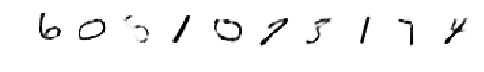

In [53]:
print(test_mean)
print(test_sigma)


plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])
plt.show()

In [32]:
print(codings_rnd[0])
print(codings_rnd[5])

[-0.86 -0.86  0.06 -2.24  0.26 -1.13 -0.56 -1.03 -1.35 -1.87  1.56 -1.75
  1.39  0.03 -0.55  0.75 -1.24  0.71  0.62  0.7  -0.13 -0.09 -0.57  1.8
  1.66  0.6  -1.35 -1.04 -0.13 -0.7  -0.75 -1.04  0.64 -0.14 -0.49 -0.51
  0.83 -0.09 -0.25 -0.87 -0.18 -0.74 -0.36  0.8   0.5   0.18  0.39 -1.15
 -1.11 -0.27]
[-0.98 -0.47 -0.62 -0.92 -0.98 -1.22  1.73  1.12  0.36 -0.56  0.99  0.83
 -0.41 -0.02  0.56  0.02  1.17  0.22  2.15 -1.45 -0.76 -0.02  1.63 -2.56
 -1.83 -0.81 -1.88 -0.43  1.02  1.19  0.6  -1.99 -0.81 -1.43 -0.88 -1.18
  1.31 -0.66  0.31  2.15  0.96 -0.88  1.45 -0.36 -0.86  0.74  1.66  0.44
  0.66  0.4 ]


In [54]:
latent_list = np.zeros((20,50))
for i in range(20):
    latent_list[i] = (i/19)*codings_rnd[0] + ((19-i)/19)*codings_rnd[5]

In [55]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(TITLE + '.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
   
    outputs_val = outputs.eval(feed_dict={latent: latent_list})    

INFO:tensorflow:Restoring parameters from ./VAE_mnist_FCN


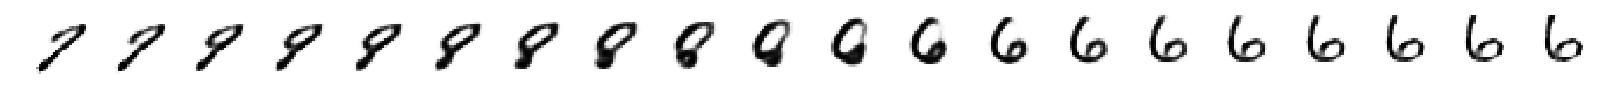

In [56]:
n_digits = 20
plt.figure(figsize=(28,28))
for iteration in range(n_digits):
    plt.subplot(n_digits/20, 20, iteration + 1)
    plot_image(outputs_val[iteration])
plt.show()